In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import pandas as pd
from edward.models import Normal

plt.style.use('ggplot')

/Users/sharmila/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/sharmila/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/sharmila/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/sharmila/.local/lib/python3.6/site-packages/tensorflow/python/framework/dty

In [2]:
''' function definitions '''
# true low-fidelity and true high-fidelity models
f_l = lambda x: (0.5*(6*x-2)**2*np.sin(12*x-4))+(10*(x-0.5))+(-5)
f_h = lambda x: ((6*x-2)**2*np.sin(12*x-4))

In [3]:
N_l = 11 # number of low fidelity data observations
N_h = 4 # number of high fidelity data observations

# [X_l,Y_l] and [X_h,Y_h] are low are high fidelity data respectively.
X_l = np.linspace(0.0, 1.0, N_l)[:, None]

# # for not-nested data
# X_h = np.random.rand(N_h, 1)

# # for nested data
perm = np.random.permutation(N_l)
X_h = X_l[perm[0:N_h]]

Y_l = f_l(X_l)
Y_h = f_h(X_h)

Y_l = Y_l.flatten()
Y_h = Y_h.flatten()

print (X_l.shape, Y_l.shape)
print (X_h.shape, Y_h.shape)

(11, 1) (11,)
(4, 1) (4,)


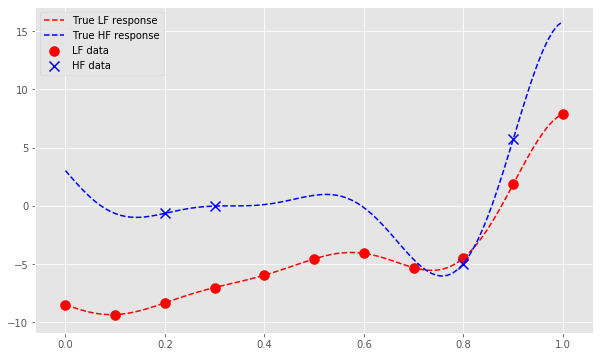

In [4]:
# just to show the plot
X_p = np.linspace(0.0, 1.0, 100)[:, None]

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.plot(X_p, f_l(X_p), 'r--', label='True LF response')
ax.scatter(X_l, Y_l, color='red', marker='o', s=100, label='LF data')
ax.plot(X_p, f_h(X_p), 'b--', label='True HF response')
ax.scatter(X_h, Y_h, color='blue', marker='x', s=100, label='HF data')

ax.legend()
plt.show()

In [5]:
ed.set_seed(42)

In [6]:
def swish(x):
    return x * tf.nn.sigmoid(x)


# Neural network number of neurons [D,H,H,1]
def neural_network(x, W_0, W_1, W_2, b_0, b_1, b_2):
    h = swish(tf.matmul(x, W_0) + b_0)
    h = swish(tf.matmul(h, W_1) + b_1)
    h = tf.matmul(h, W_2) + b_2
    return tf.reshape(h, [-1])

## Low fidelity BNN

In [7]:
D = np.shape(X_l)[1]  # number of features or number of input neurons
H = 10
print (D,H) 


# prior
W_0 = Normal(loc=tf.zeros([D, H]), scale=tf.ones([D, H]),name="W_0")
W_1 = Normal(loc=tf.zeros([H, H]), scale=tf.ones([H, H]), name="W_1")
W_2 = Normal(loc=tf.zeros([H, 1]), scale=tf.ones([H, 1]), name="W_2")
b_0 = Normal(loc=tf.zeros(H), scale=tf.ones(H), name="b_0")
b_1 = Normal(loc=tf.zeros(H), scale=tf.ones(H), name="b_1")
b_2 = Normal(loc=tf.zeros(1), scale=tf.ones(1), name="b_2")

#likelihood
X = tf.placeholder(tf.float32, [None, D], name="X")
Y = Normal(loc=neural_network(X, W_0, W_1, W_2, b_0, b_1, b_2),
           scale=0.01 , name="Y")

1 10


q's are random variables defined to approximate the posterior [http://edwardlib.org/api/inference]

In [8]:
qW_0 = Normal(loc=tf.get_variable("qW_0/loc", [D, H]),
              scale=tf.nn.softplus(tf.get_variable("qW_0/scale", [D, H])))
qW_1 = Normal(loc=tf.get_variable("qW_1/loc", [H, H]),
              scale=tf.nn.softplus(tf.get_variable("qW_1/scale", [H, H])))
qW_2 = Normal(loc=tf.get_variable("qW_2/loc", [H, 1]),
              scale=tf.nn.softplus(tf.get_variable("qW_2/scale", [H, 1])))
qb_0 = Normal(loc=tf.get_variable("qb_0/loc", [H]),
              scale=tf.nn.softplus(tf.get_variable("qb_0/scale", [H])))
qb_1 = Normal(loc=tf.get_variable("qb_1/loc", [H]),
              scale=tf.nn.softplus(tf.get_variable("qb_1/scale", [H])))
qb_2 = Normal(loc=tf.get_variable("qb_2/loc", [1]),
              scale=tf.nn.softplus(tf.get_variable("qb_2/scale", [1])))

In [9]:
X_p = np.linspace(0.0, 1.0, 100)[:, None]
X_p = np.float32(X_p)
print (X_p.shape)

(100, 1)


In [10]:
# Sample functions from variational model to visualize fits.
qW_0_s = qW_0.sample(1000)
qW_1_s = qW_1.sample(1000)
qW_2_s = qW_2.sample(1000)
qb_0_s = qb_0.sample(1000)
qb_1_s = qb_1.sample(1000)
qb_2_s = qb_2.sample(1000)
preds = tf.stack(
    [neural_network(X_p, qW_0_s[i], qW_1_s[i], qW_2_s[i],
                    qb_0_s[i], qb_1_s[i], qb_2_s[i])
     for i in range(1000)])

(1000, 100)
(100,)
(999, 100)


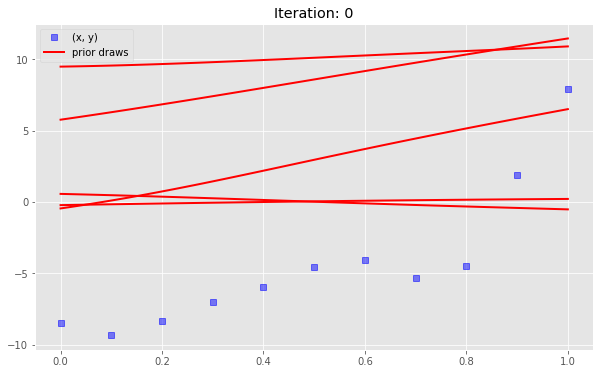

In [11]:
# FIRST VISUALIZATION (prior) #before optimization

sess = ed.get_session()
tf.global_variables_initializer().run()
outputs = preds.eval()

print(np.shape(outputs))
print(np.shape(outputs[0]))
print(np.shape(outputs[1:]))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("Iteration: 0")
ax.plot(X_l, Y_l, 'bs', alpha=0.5, label='(x, y)') # full data (train+test)
ax.plot(X_p, outputs[0].T, lw=2, label='prior draws', color='red')
ax.plot(X_p, outputs[1:5].T, lw=2, color='red')
ax.legend()
plt.show()

/Users/sharmila/anaconda3/envs/py36/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


5000/5000 [100%] ██████████████████████████████ Elapsed: 16s | Loss: 1471.948


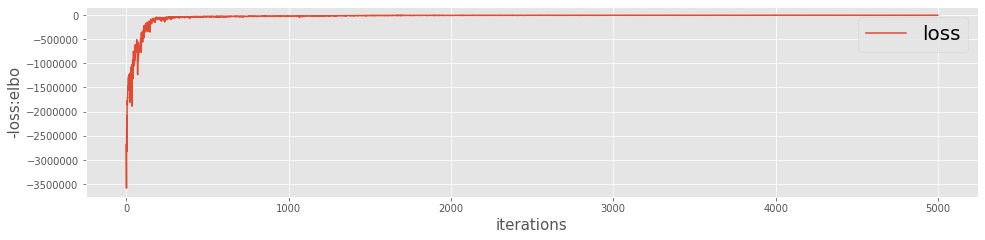

In [12]:
inference = ed.KLqp({W_0: qW_0, b_0: qb_0,
                     W_1: qW_1, b_1: qb_1,
                     W_2: qW_2, b_2: qb_2}, data={X:X_l, Y:Y_l})

# inference.run(n_iter=1000, n_samples=5)

#or

#reference:
# http://edwardlib.org/tutorials/mixture-density-network
# http://edwardlib.org/api/inference
inference.initialize(n_iter=5000, n_samples=5)
LOSS = np.zeros(inference.n_iter)
tf.global_variables_initializer().run()
for i in range(inference.n_iter):
    info_dict = inference.update()
    LOSS[i] = info_dict['loss']
    inference.print_progress(info_dict)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
plt.plot(np.arange(inference.n_iter), -LOSS, label='loss')
plt.legend(fontsize=20)
plt.xlabel('iterations', fontsize=15)
plt.ylabel('-loss:elbo', fontsize=15)
plt.show()    


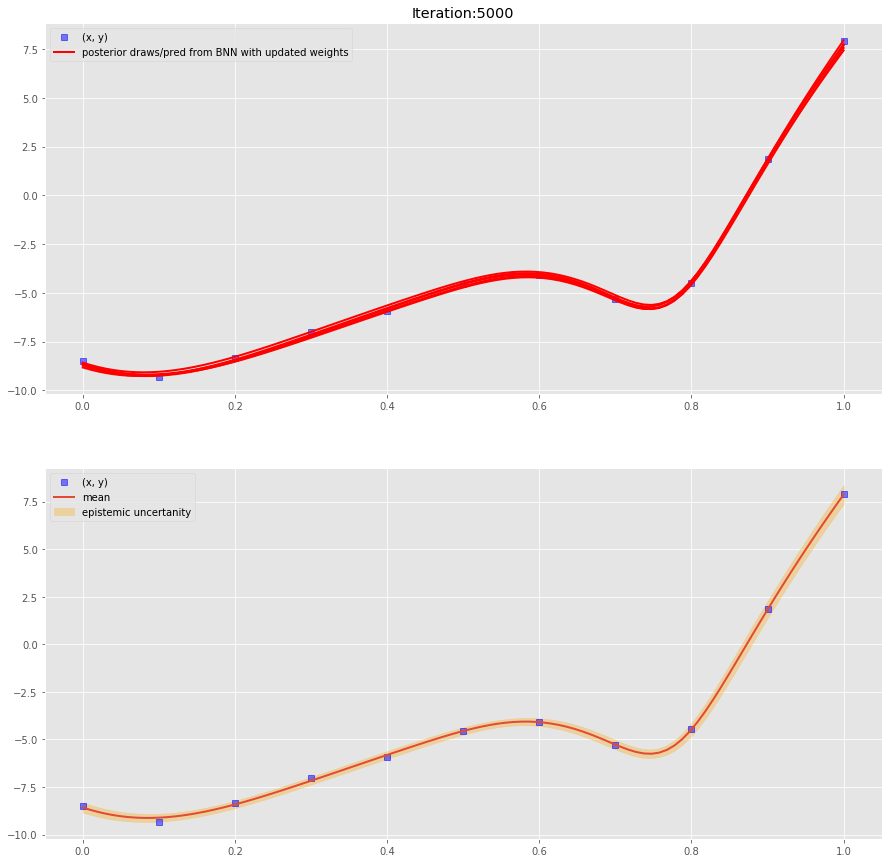

In [13]:
# SECOND VISUALIZATION (posterior) #after optimization

outputs = preds.eval()

fig = plt.figure(figsize=(15, 15))

ax1 = fig.add_subplot(211)
ax1.set_title("Iteration:"+str(inference.n_iter))
ax1.plot(X_l, Y_l, 'bs', alpha=0.5, label='(x, y)') # full data (train+test)
ax1.plot(X_p, outputs[0].T, lw=2, label='posterior draws/pred from BNN with updated weights', color='red')
ax1.plot(X_p, outputs[1:5].T, lw=2, color='red')
ax1.legend()


mean_pred = np.mean(outputs, axis=0)
std_pred = np.std(outputs, axis=0)
ax2 = fig.add_subplot(212)
ax2.plot(X_l, Y_l, 'bs', alpha=0.5, label='(x, y)') # full data (train+test)
ax2.plot(X_p, mean_pred , lw=2,label='mean')
ax2.fill_between(X_p.ravel(), mean_pred-2*std_pred, mean_pred+2*std_pred, alpha = 0.3, color = 'orange',label='epistemic uncertanity')
ax2.legend()

plt.show()

## High fidelity BNN

In [14]:
D = np.shape(X_h)[1]  # number of features or number of input neurons
H = 10
print (D,H) 


# prior
W_0h = Normal(loc=qW_0.loc.eval(), scale=qW_0.scale.eval(), name="W_0h")
W_1h = Normal(loc=qW_1.loc.eval(), scale=qW_1.scale.eval(), name="W_1h")
W_2h = Normal(loc=qW_2.loc.eval(), scale=qW_2.scale.eval(), name="W_2h")
b_0h = Normal(loc=qb_0.loc.eval(), scale=qb_0.scale.eval(), name="b_0h")
b_1h = Normal(loc=qb_1.loc.eval(), scale=qb_1.scale.eval(), name="b_1h")
b_2h = Normal(loc=qb_2.loc.eval(), scale=qb_2.scale.eval(), name="b_2h")

#likelihood
Xh = tf.placeholder(tf.float32, [None, D], name="Xh")
Yh = Normal(loc=neural_network(Xh, W_0h, W_1h, W_2h, b_0h, b_1h, b_2h),
           scale=0.01 , name="Yh")

1 10


In [15]:
qW_0h = Normal(loc=tf.get_variable("qW_0h/loc", [D, H]),
              scale=tf.nn.softplus(tf.get_variable("qW_0h/scale", [D, H])))
qW_1h = Normal(loc=tf.get_variable("qW_1h/loc", [H, H]),
              scale=tf.nn.softplus(tf.get_variable("qW_1h/scale", [H, H])))
qW_2h = Normal(loc=tf.get_variable("qW_2h/loc", [H, 1]),
              scale=tf.nn.softplus(tf.get_variable("qW_2h/scale", [H, 1])))
qb_0h = Normal(loc=tf.get_variable("qb_0h/loc", [H]),
              scale=tf.nn.softplus(tf.get_variable("qb_0h/scale", [H])))
qb_1h = Normal(loc=tf.get_variable("qb_1h/loc", [H]),
              scale=tf.nn.softplus(tf.get_variable("qb_1h/scale", [H])))
qb_2h = Normal(loc=tf.get_variable("qb_2h/loc", [1]),
              scale=tf.nn.softplus(tf.get_variable("qb_2h/scale", [1])))

In [16]:
X_p = np.linspace(0.0, 1.0, 100)[:, None]
X_p = np.float32(X_p)
print (X_p.shape)

(100, 1)


In [17]:
# Sample functions from variational model to visualize fits.
qW_0h_s = qW_0h.sample(1000)
qW_1h_s = qW_1h.sample(1000)
qW_2h_s = qW_2h.sample(1000)
qb_0h_s = qb_0h.sample(1000)
qb_1h_s = qb_1h.sample(1000)
qb_2h_s = qb_2h.sample(1000)
preds_h = tf.stack(
    [neural_network(X_p, qW_0h_s[i], qW_1h_s[i], qW_2h_s[i],
                    qb_0h_s[i], qb_1h_s[i], qb_2h_s[i])
     for i in range(1000)])

(1000, 100)
(100,)
(999, 100)


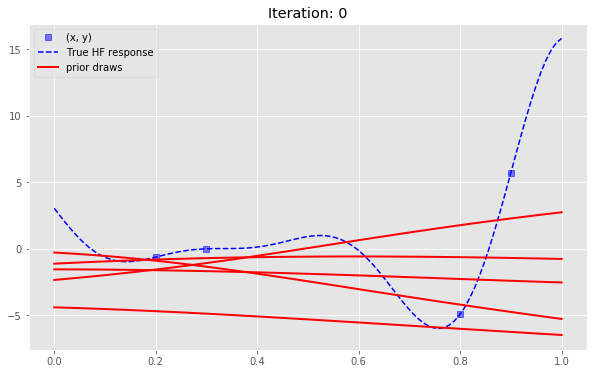

In [18]:
# FIRST VISUALIZATION (prior) #before optimization

sess = ed.get_session()
tf.global_variables_initializer().run()
outputs_h = preds_h.eval()

print(np.shape(outputs_h))
print(np.shape(outputs_h[0]))
print(np.shape(outputs_h[1:]))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("Iteration: 0")
ax.plot(X_h, Y_h, 'bs', alpha=0.5, label='(x, y)') # full data (train+test)
ax.plot(X_p, f_h(X_p), 'b--', label='True HF response')
ax.plot(X_p, outputs_h[0].T, lw=2, label='prior draws', color='red')
ax.plot(X_p, outputs_h[1:5].T, lw=2, color='red')
ax.legend()
plt.show()

100000/100000 [100%] ██████████████████████████████ Elapsed: 181s | Loss: 505275.844


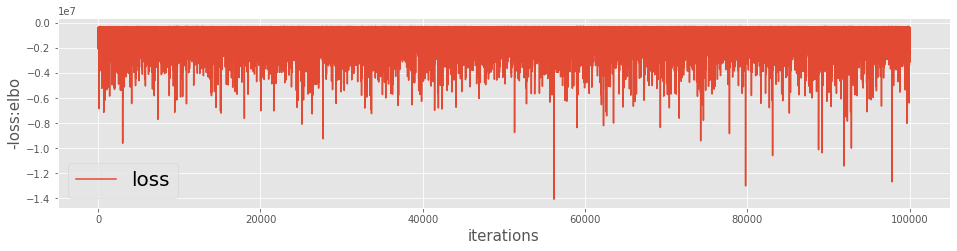

In [19]:
inference = ed.KLqp({W_0h: qW_0h, b_0h: qb_0h,
                     W_1h: qW_1h, b_1h: qb_1h,
                     W_2h: qW_2h, b_2h: qb_2h}, data={X:X_h, Y:Y_h})

# inference.run(n_iter=1000, n_samples=5)

#or

#reference:
# http://edwardlib.org/tutorials/mixture-density-network
# http://edwardlib.org/api/inference
inference.initialize(n_iter=100000, n_samples=5)
LOSS = np.zeros(inference.n_iter)
tf.global_variables_initializer().run()
for i in range(inference.n_iter):
    info_dict = inference.update()
    LOSS[i] = info_dict['loss']
    inference.print_progress(info_dict)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
plt.plot(np.arange(inference.n_iter), -LOSS, label='loss')
plt.legend(fontsize=20)
plt.xlabel('iterations', fontsize=15)
plt.ylabel('-loss:elbo', fontsize=15)
plt.show()    


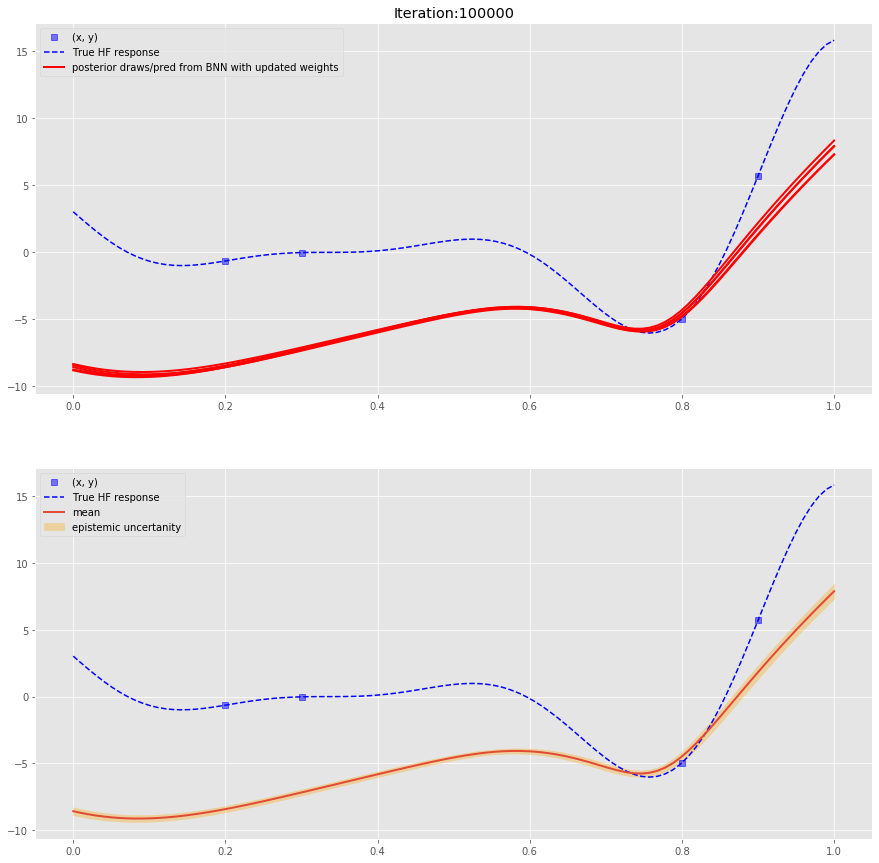

In [20]:
# SECOND VISUALIZATION (posterior) #after optimization

outputs_h = preds_h.eval()

fig = plt.figure(figsize=(15, 15))

ax1 = fig.add_subplot(211)
ax1.set_title("Iteration:"+str(inference.n_iter))
ax1.plot(X_h, Y_h, 'bs', alpha=0.5, label='(x, y)') # full data (train+test)
ax1.plot(X_p, f_h(X_p), 'b--', label='True HF response')
ax1.plot(X_p, outputs_h[0].T, lw=2, label='posterior draws/pred from BNN with updated weights', color='red')
ax1.plot(X_p, outputs_h[1:5].T, lw=2, color='red')
ax1.legend()


mean_pred_h = np.mean(outputs_h, axis=0)
std_pred_h = np.std(outputs_h, axis=0)
ax2 = fig.add_subplot(212)
ax2.plot(X_h, Y_h, 'bs', alpha=0.5, label='(x, y)') # full data (train+test)
ax2.plot(X_p, f_h(X_p), 'b--', label='True HF response')
ax2.plot(X_p, mean_pred_h , lw=2,label='mean')
ax2.fill_between(X_p.ravel(), mean_pred_h-2*std_pred_h, mean_pred_h+2*std_pred_h, alpha = 0.3, color = 'orange',label='epistemic uncertanity')
ax2.legend()

plt.show()